# The committor of a realistic protein folding trajectory

In this notebook we will determine the putative committor of a long equilibrium protein folding trajectory of HP35 Nle/Nle double mutant consisting of 1509392 snapshots at 380 K.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="The raw code for this Python notebook is by default hidden for easier reading. Click here to toggle on/off the raw code."></form>''')

We first import some libraries and define following functions to
 - read coordinates from a dcd file
 - compute distance time-series between two atoms
 - find point where Z_C,1 deviates most from the average 

In [2]:
import tensorflow as tf
import npnelib as ne
import numpy as np

def read_dcd(name,verb=False,natom=0,nsets=0):
    import numpy as np
    from scipy.io import FortranFile
    f=FortranFile(name,'r')
    hdr=f.read_record(np.dtype('i4'))
    if verb:print (hdr)
    nsetsdcd=hdr[1]
    if nsets==0:nsets=nsetsdcd
    extrablock=hdr[11]>0
    if verb:print (nsets,extrablock)
    ntitle=f.read_record(np.dtype('i4'))
    if verb:print (ntitle)
    natomdcd=f.read_record(np.dtype('i4'))[0]
    if natom==0:natom=natomdcd
    mask=np.full(natomdcd,True)
    if natomdcd!=natom: # reading a (random) subset of atoms
        mask=np.full(natomdcd,False)
        mask[:natom]=True
        np.random.shuffle(mask)
    if verb:print (natom)
    xyz=np.zeros((natom,3,nsets),dtype=np.float16)
    for iset in range(nsets):
        if iset % max(1,int(nsets/10))==0:print (iset)
        if extrablock: cell=f.read_record(np.dtype('f4'))
        xyz[:,0,iset]=f.read_record(np.dtype('f4'))[mask]
        xyz[:,1,iset]=f.read_record(np.dtype('f4'))[mask]
        xyz[:,2,iset]=f.read_record(np.dtype('f4'))[mask]
    f.close()
    return natom,nsets,xyz

@tf.function
def rij(r1,r2):
    dr=r1-r2
    dr2=tf.math.reduce_sum(dr*dr,axis=0)
    dr=tf.math.sqrt(dr2)
    return dr/tf.math.reduce_max(dr)

def find_maxzc1(r):
    lx,lzc1=ne.comp_Zca(r,1,dx=0.0001,dt=1)
    mzc1=sum(lzc1)/len(lzc1)
    return max([((zc1/mzc1-1),x) for x,zc1 in zip(lx,lzc1)])

### Reading rmsd and dcd
We read the order parameter, the rmsd from the native pdb structure to define the boundary states and read coordinates from the dcd file.

In [3]:
f=open('2f4kpnas380.CArmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()
rmsd=np.asarray(lrmsd)

natom,nsets,xyz=read_dcd('2f4kpnas380.dcd')
xyz = tf.convert_to_tensor(xyz, np.float16)

print (xyz.shape)

0
150939
301878
452817
603756
754695
905634
1056573
1207512
1358451
1509390
(577, 3, 1509392)


### Auxiliary time-series: $I_t(t)$, $I_b(t)$ and the seed committor $r(t)$
are computed as
 - $I_t(i)=1$ if **itraj[i]=itraj[i+1]** and 0 otherwise
 - $I_b(i)=1$ when point/frame $i$ belongs to a boundary state and 0 otherwise
 - r(i)=0 or 1 when point/frame $i$ belongs to A or B and 0.5 otherwise.  
 
We define the following boundary states for the committor, A: $R\le 1$ and B: $R\ge 10.5$, here R is the rmsd from the native structure.

In [4]:
import numpy as np
r=np.ones_like(rmsd,np.float64)/2
r[rmsd<1.0]=1
r[rmsd>10.5]=0

Ib=np.zeros_like(rmsd,np.float64)
Ib[rmsd<1.0]=1 
Ib[rmsd>10.5]=1 

It=np.ones_like(rmsd,np.float64)

### Optimization using NPNEq

#### Iterations:
 - NPNEq with f(r,y) polynomial of 4-th degree.
 - every 400-th iteration, we find point $r_0$ on $Z_{C,1}$ profile that is maximal (most different from the average). every 40th iteration we optimize using an envelope around $r_0$ and f(r) polynomial of 16-th degree.
 - NPNEq with f(r) polynomial of 16-th degree.

#### Stopping:
Iterations stop, when number of iterations has reached 40000


#### Output
every 1000 iterations we print:   
iteration number, $||r-r_{-1000}||$, $\Delta r^2/2$, $\max \Delta Z_{C,1}$, $r_0$

In [5]:
ro=r
df=0
r0=0
lr1=[]
lr2=[]
k=0
np.random.seed(100)
while k<1000000:
    i,j=np.random.choice(range(natom),2,replace=False)
    y=rij(xyz[i,:,:],xyz[j,:,:])
    y=tf.cast(y,tf.float64)
    
    r=ne.NPNEq(r,ne.basis_poly_ry(r,y,4),Ib,It)
    
    if k%40==0 and k>=400:
        if k%400==0:df,r0=find_maxzc1(r.numpy())
        if df>0.03:
            d=0.1**(1+3*np.random.random())
            fenv=tf.math.exp(-tf.math.abs(r0-r)/d)
            r=ne.NPNEq(r,ne.basis_poly_r(r,16,fenv=fenv),Ib,It)
    
    r=ne.NPNEq(r,ne.basis_poly_r(r,16),Ib,It)
    
    if k%1000==0:
        dr=r-ro
        dr2=tf.tensordot(dr,dr,1).numpy()
        dr2=dr2**0.5
        lr1.append((k,dr2))
        dr=r-tf.roll(r,-1,0)
        dr2=tf.tensordot(dr*It,dr,1).numpy()/2
        lr2.append((k,dr2))
        print (k,lr1[-1][1],lr2[-1][1],df,r0)
        if k>=40000:break
        ro=r
    k+=1

0 107.92162680705111 2388.163090084881 0 0
1000 422.1738027305109 329.75008889767184 0.22877309528488987 0.1042
2000 19.757891480751475 270.1915775215464 0.253125972640607 0.8410000000000001
3000 11.626446155564802 242.82255928869384 0.10765831760386746 0.0806
4000 7.560412388208008 225.74907357715242 0.08575971894040846 0.0761
5000 5.871170363645533 215.21241683745856 0.08110374557953692 0.8490000000000001
6000 4.2942691940179945 207.95673078881657 0.053791478779160906 0.9538000000000001
7000 4.492658838013996 201.3823180884578 0.0647638362609988 0.0712
8000 5.207499767628369 196.08395415370336 0.0660631454976015 0.8551000000000001
9000 4.983049228259716 191.19260991254663 0.09202814046369179 0.859
10000 4.327197165957762 186.72517721465098 0.0583069834401575 0.0682
11000 4.925350912952099 182.09367062645148 0.05104175934057009 0.0201
12000 3.442820676774242 179.07290549249672 0.1131359451542171 0.8668
13000 2.9375647936304183 175.89561664062924 0.06589685245740617 0.8684000000000001


### The figure

This part of the notebook prepares figure for the paper

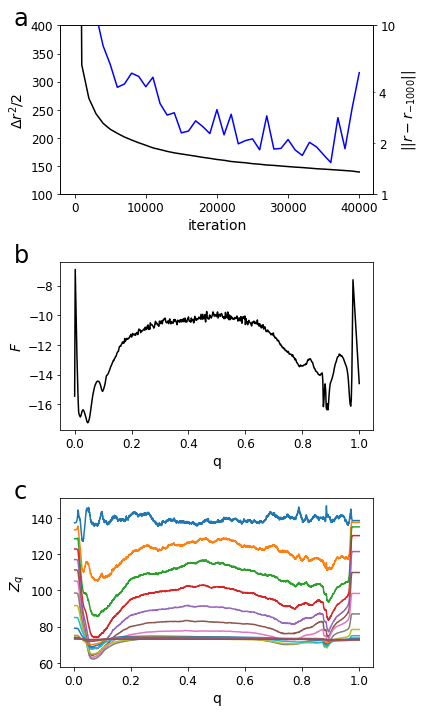

In [6]:
qp=r.numpy()
ar1=np.asarray(lr1)
ar2=np.asarray(lr2)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(6,10))
        
ax1b=ax1.twinx()
ax1b.plot(ar1[1:,0],ar1[1:,1],'b')
ax1b.set(ylabel='$||r-r_{-1000}||$')

from matplotlib.ticker import FormatStrFormatter
ax1b.set(yscale='log',ylim=(1,10))
ax1b.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1b.yaxis.set_minor_formatter(FormatStrFormatter('%g'))
ax1b.yaxis.set_ticks([1,2,4,10],minor=True)
ax1.set(xlabel='iteration',ylabel='$\Delta r^2/2$')
ax1.plot(ar2[:,0],ar2[:,1],'k')
_=ax1.set(ylim=(100,400))


import npnelib as ne 
from math import log

dx=0.002
lx,lzh=ne.comp_Zh(qp,dx=dx)
lf=[-log(z) for z in lzh if z>0]

lx2,lzh2=ne.comp_Zca(qp,a=-1,dx=dx,eq=True)
lf2=[-log(z*2) for z in lzh2 if z>0]

ax2.plot(lx,lf,'k-',label='$F_H$')
ax2.set(xlabel='q',ylabel='$F$')

dx=0.0001
ldt=[2**i for i in range(16)]
for dt in ldt:
    ekn=ne.comp_ekn_tp(qp,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=ne.comp_Zca_ekn(ekn,a=1)
    ax3.plot(lx,lzc1)

ax3.set(xlabel='q',ylabel='$Z_q$')
ax1.text(-.15,1,'a',fontsize=24,transform=ax1.transAxes)
ax2.text(-.15,1,'b',fontsize=24,transform=ax2.transAxes)
ax2.text(-.15,1,'c',fontsize=24,transform=ax3.transAxes)

plt.tight_layout()
_=plt.savefig('fig5.pdf',dpi=600)